In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
import time
import warnings

In [157]:
df = pd.read_csv(".../sample.csv")

In [158]:
df.head()

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   loc1    10000 non-null  object 
 1   loc2    10000 non-null  object 
 2   para1   10000 non-null  int64  
 3   dow     10000 non-null  object 
 4   para2   10000 non-null  int64  
 5   para3   10000 non-null  float64
 6   para4   10000 non-null  float64
 7   price   10000 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 625.1+ KB


# Data Manipulation

In [160]:
# Remove rows where 'loc1' contains 'S' or 'T'
df = df[(df["loc1"].str.contains("S") == False) & (df["loc1"].str.contains("T") == False)]


In [161]:
# Convert 'loc2' and 'loc1' columns to numeric values
df["loc2"] = pd.to_numeric(df["loc2"], errors='coerce')
df["loc1"] = pd.to_numeric(df["loc1"], errors='coerce')

In [162]:
df.dropna(inplace=True)

In [163]:
# Map days of the week to numeric values
days_of_week = {'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7}
df['dow'] = df['dow'].map(days_of_week)

In [164]:
dow_dummies = pd.get_dummies(df['dow']).astype(int)
df = df.drop(columns='dow').join(dow_dummies)

In [165]:
df.columns = df.columns.astype(str)

In [166]:
df.head()

,loc1,loc2,para1,para2,para3,para4,price,1,2,3,4,5,6,7
0,0,1.0,1,662,3000.0,3.8,73.49,1,0,0,0,0,0,0
1,9,99.0,1,340,2760.0,9.2,300.00,0,0,0,1,0,0,0
2,0,4.0,0,16,2700.0,3.0,130.00,1,0,0,0,0,0,0
3,4,40.0,1,17,12320.0,6.4,365.00,1,0,0,0,0,0,0
4,5,50.0,1,610,2117.0,10.8,357.50,0,0,0,1,0,0,0


# Feature Selection

In [167]:
correlation_matrix = df.corr()
print(correlation_matrix["price"].sort_values(ascending=False))

price    1.000000
para2    0.551222
para4    0.517614
para3    0.356949
para1    0.074555
5        0.025674
1        0.021734
6        0.014918
7        0.004176
2       -0.000974
4       -0.019656
3       -0.026684
loc2    -0.043543
loc1    -0.044079
Name: price, dtype: float64


In [168]:
# Select top 5 features based on correlation
top_features = correlation_matrix["price"].sort_values(ascending=False).index[1:6]
print("Top 5 features:", top_features)

Top 5 features: Index(['para2', 'para4', 'para3', 'para1', '5'], dtype='object')


# Machine Learning Models

In [169]:
feature_sets = {
    "full_dataset": df.drop(columns=['price']),
    "top_5_features": df[top_features]
}

In [170]:
regression_models = {
    "Ridge": Ridge(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42, max_depth=6),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "LGBM": LGBMRegressor(random_state=42),
    "MLP": MLPRegressor(random_state=42)
}

In [171]:
# Function to train and evaluate models
def make_regression(x_train, y_train, x_test, y_test, model, model_name, verbose=True):
    model.fit(x_train, y_train)
    
    y_predict = model.predict(x_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    
    y_predict = model.predict(x_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    
    r2 = r2_score(y_train, y_predict)
    
    if verbose:
        print("----Model name = {}-----".format(model_name))
        print("Train error = '{}'".format(train_error))
        print("Test error = '{}'".format(test_error))
        print("r2_score = '{}'".format(r2))
        print("--------------------------------")
    
    return model, y_predict, train_error, test_error, r2


In [172]:
# Dictionary to store results
pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "Train Error": [],
    "Test Error": [],
    "R2": []
}

In [173]:
# Iterate through feature sets and models
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    print(f"Included columns are {feature_set_name}")
    for model_name in regression_models.keys():
        model = regression_models[model_name]
        y = df["price"]
        x = feature_set
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        trained_model, y_predict, train_error, test_error, r2 = make_regression(x_train, y_train, x_test, y_test, model, model_name)
        pred_dict["regression_model"].append(model_name)
        pred_dict["feature_set"].append(feature_set_name)
        pred_dict["Train Error"].append(train_error)
        pred_dict["Test Error"].append(test_error)
        pred_dict["R2"].append(r2)



Included columns are full_dataset
----Model name = Ridge-----
Train error = 182.3008389770927
Test error = 187.45395213331855
r2_score = 0.5548540898601966
--------------------------------
----Model name = DecisionTree-----
Train error = 145.75128239798423
Test error = 166.92951573170672
r2_score = 0.7154557446549819
--------------------------------
----Model name = RandomForest-----
Train error = 56.943878064347984
Test error = 154.68383406858914
r2_score = 0.9565670693747674
--------------------------------
----Model name = XGBoost-----
Train error = 78.18661456510331
Test error = 181.54149282847226
r2_score = 0.9181177306486643
--------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 7994, number of used features: 11
[LightGBM] [Info] Start training from sco

In [174]:
pred_df = pd.DataFrame(pred_dict)

In [175]:
pred_df.head()

,regression_model,feature_set,Train Error,Test Error,R2
0,Ridge,full_dataset,182.300839,187.453952,0.554854
1,DecisionTree,full_dataset,145.751282,166.929516,0.715456
2,RandomForest,full_dataset,56.943878,154.683834,0.956567
3,XGBoost,full_dataset,78.186615,181.541493,0.918118
4,LGBM,full_dataset,122.427296,157.456725,0.799238


 # Grid Search for Random Forest

In [176]:
# Suppress specific sklearn warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [177]:
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'ccp_alpha': [0.0],
    'criterion': ['squared_error'],
    'max_depth': [None],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None],
    'max_samples': [None],
    'min_impurity_decrease': [0.0],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'min_weight_fraction_leaf': [0.0],
    'n_estimators': [50, 500, 700],
    'n_jobs': [None],
    'oob_score': [True, False],
    'random_state': [42],
    'verbose': [0],
    'warm_start': [True, False],
}


In [178]:
# Create a base model
rf = RandomForestRegressor()


In [179]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=3, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')

start = time.time()
grid_search.fit(x_train, y_train)
end = time.time()

elapsed_time_seconds = end - start
elapsed_time = elapsed_time_seconds / 60
elapsed_time_seconds = round(elapsed_time_seconds, 2)
elapsed_time = round(elapsed_time, 2)

print('Execution time:', elapsed_time_seconds, 'seconds which is:', elapsed_time, 'minutes.')
best_params = grid_search.best_params_

Execution time: 63.18 seconds which is: 1.05 minutes.


In [180]:
# Train the Random Forest with the best parameters from Grid Search
model = RandomForestRegressor()
model.set_params(**best_params)

model_name = "Random Forest"

model.fit(x_train, y_train)

y_predict = model.predict(x_train)
train_error_gr = mean_squared_error(y_train, y_predict, squared=False)

y_predict = model.predict(x_test)
test_error_gr = mean_squared_error(y_test, y_predict, squared=False)

y_predict = model.predict(x_train)
r2_gr = r2_score(y_train, y_predict)

print("----Model name = {}-----".format(model_name))
print("Train error = '{}'".format(train_error_gr))
print("Test error = '{}'".format(test_error_gr))
print("r2_score = '{}'".format(r2_gr))
print("--------------------------------")


----Model name = Random Forest-----
Train error = '58.49133060721946'
Test error = '160.5027147821223'
r2_score = '0.9541744110550547'
--------------------------------


In [181]:
train_error_f = train_error_gr
test_error_f = test_error_gr
r2_f = r2_gr

# SCALING

### Min-Max Scaling

In [182]:
x = df.drop(columns=['price'])
y = df["price"]
y = np.asanyarray(y).reshape(-1, 1)

x_scaler = MinMaxScaler()
x_scaler.fit(X=x, y=y)
x_scaled = x_scaler.transform(x)

y_scaler = MinMaxScaler()
y_scaler.fit(y)
y_scaled = y_scaler.transform(y)

x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    x_scaled, y_scaled, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.set_params(**best_params)
model.fit(x_train_scaled, y_train_scaled)

y_predict_scaled = model.predict(x_train_scaled)
y_predict_train_minmax = y_scaler.inverse_transform(y_predict_scaled.reshape(-1, 1))
rmse_error_train_minmax = mean_squared_error(y_train, y_predict_train_minmax[:, 0], squared=False)
r2_mm = r2_score(y_train, y_predict_train_minmax)

model.fit(x_test_scaled, y_test_scaled)

y_predict_scaled_t = model.predict(x_test_scaled)
y_predict_test_minmax = y_scaler.inverse_transform(y_predict_scaled_t.reshape(-1, 1))
rmse_error_test_minmax = mean_squared_error(y_test, y_predict_test_minmax[:, 0], squared=False)

print("Normalized Train error = '{}'".format(rmse_error_train_minmax))
print("Normalized Test error = '{}'".format(rmse_error_test_minmax))
print("Normalized r2_score = '{}'".format(r2_mm))

Normalized Train error = '57.50402922523972'
Normalized Test error = '160.8055625902965'
Normalized r2_score = '0.9557083759268272'


### Standard Scaling

In [183]:
x_scaler = StandardScaler()
x_scaler.fit(X=x, y=y)
x_scaled = x_scaler.transform(x)

y_scaler = StandardScaler()
y_scaler.fit(y)
y_scaled = y_scaler.transform(y)

x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    x_scaled, y_scaled, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.set_params(**best_params)
model.fit(x_train_scaled, y_train_scaled)

y_predict_scaled = model.predict(x_train_scaled)
y_predict_train_standard = y_scaler.inverse_transform(y_predict_scaled.reshape(-1, 1))
rmse_error_train_standard = mean_squared_error(y_train, y_predict_train_standard[:, 0], squared=False)
r2_standard = r2_score(y_train, y_predict_train_standard)

model.fit(x_test_scaled, y_test_scaled)

y_predict_scaled_t = model.predict(x_test_scaled)
y_predict_test_standard = y_scaler.inverse_transform(y_predict_scaled_t.reshape(-1, 1))
rmse_error_test_standard = mean_squared_error(y_test, y_predict_test_standard[:, 0], squared=False)

print("Standardized Train error = '{}'".format(rmse_error_train_standard))
print("Standardized Test error = '{}'".format(rmse_error_test_standard))
print("Standardized r2_score = '{}'".format(r2_standard))

Standardized Train error = '57.66448452503548'
Standardized Test error = '160.2206527363088'
Standardized r2_score = '0.9554608544534733'


### Robust Scaling


In [184]:
x_scaler = RobustScaler()
x_scaler.fit(X=x, y=y)
x_scaled = x_scaler.transform(x)

y_scaler = RobustScaler()
y_scaler.fit(y)
y_scaled = y_scaler.transform(y)

x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    x_scaled, y_scaled, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.set_params(**best_params)
model.fit(x_train_scaled, y_train_scaled)

y_predict_scaled = model.predict(x_train_scaled)
y_predict_train_robust = y_scaler.inverse_transform(y_predict_scaled.reshape(-1, 1))
rmse_error_train_robust = mean_squared_error(y_train, y_predict_train_robust[:, 0], squared=False)
r2_robust = r2_score(y_train, y_predict_train_robust)

model.fit(x_test_scaled, y_test_scaled)

y_predict_scaled_t = model.predict(x_test_scaled)
y_predict_test_robust = y_scaler.inverse_transform(y_predict_scaled_t.reshape(-1, 1))
rmse_error_test_robust = mean_squared_error(y_test, y_predict_test_robust[:, 0], squared=False)

print("Robust Scaled Train error = '{}'".format(rmse_error_train_robust))
print("Robust Scaled Test error = '{}'".format(rmse_error_test_robust))
print("Robust Scaled r2_score = '{}'".format(r2_robust))

Robust Scaled Train error = '57.61839457145699'
Robust Scaled Test error = '160.84844545421527'
Robust Scaled r2_score = '0.955532024317759'


# Model Evaluation Summary

In [186]:
# Collect results in a dictionary
pred_dict = {
    "technique": ["Base Model", "Grid Search", "Min-Max Scaling", "Standard-Scaling", "Robust-Scaling"],
    "Train Error": [train_error_f, train_error_gr, rmse_error_train_minmax, rmse_error_train_standard, rmse_error_train_robust],
    "Test Error": [test_error_f, test_error_gr, rmse_error_test_minmax, rmse_error_test_standard, rmse_error_test_robust],
    "R2": [r2_f, r2_gr, r2_mm, r2_standard, r2_robust]
}

In [187]:
pred_df.head()

,regression_model,feature_set,Train Error,Test Error,R2
0,Ridge,full_dataset,182.300839,187.453952,0.554854
1,DecisionTree,full_dataset,145.751282,166.929516,0.715456
2,RandomForest,full_dataset,56.943878,154.683834,0.956567
3,XGBoost,full_dataset,78.186615,181.541493,0.918118
4,LGBM,full_dataset,122.427296,157.456725,0.799238


In [195]:
# Create DataFrame from the dictionary
pred_df = pd.DataFrame(pred_dict)

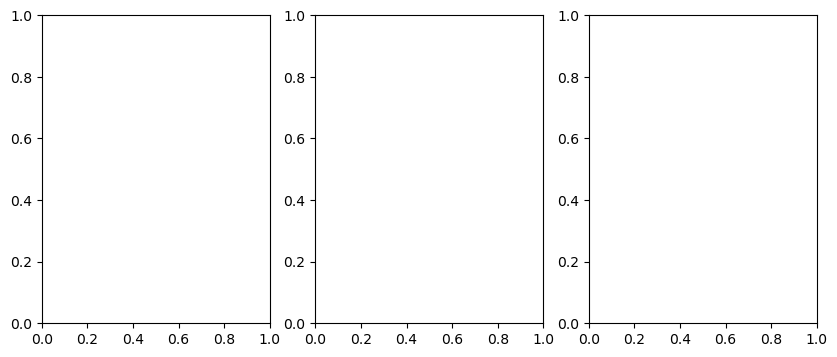

In [196]:

fig, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize=(10, 4))

          technique  Train Error  Test Error        R2
0        Base Model    58.491331  160.502715  0.954174
1       Grid Search    58.491331  160.502715  0.954174
2   Min-Max Scaling    57.504029  160.805563  0.955708
3  Standard-Scaling    57.664485  160.220653  0.955461
4    Robust-Scaling    57.618395  160.848445  0.955532


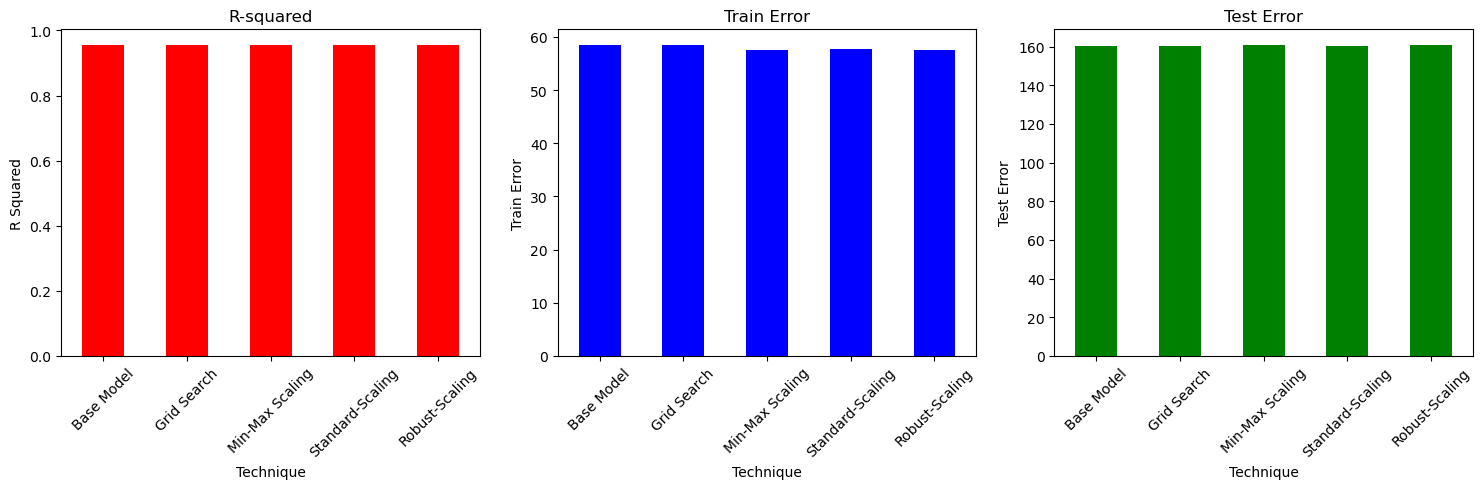

In [199]:
# Create DataFrame from the dictionary
pred_df = pd.DataFrame(pred_dict)
print(pred_df)  # Print DataFrame to ensure it has the expected data

# Create the R-squared graph
pred_df.plot(kind='bar', x='technique', y='R2', color='red', ax=ax2, legend=False)
ax2.set_xlabel('Technique')
ax2.set_ylabel('R Squared')
ax2.set_title('R-squared')
ax2.tick_params(axis='x', labelrotation=45)

# Create the Train Error graph
pred_df.plot(kind='bar', x='technique', y='Train Error', color='blue', ax=ax3, legend=False)
ax3.set_xlabel('Technique')
ax3.set_ylabel('Train Error')
ax3.set_title('Train Error')
ax3.tick_params(axis='x', labelrotation=45)

# Create the Test Error graph
pred_df.plot(kind='bar', x='technique', y='Test Error', color='green', ax=ax4, legend=False)
ax4.set_xlabel('Technique')
ax4.set_ylabel('Test Error')
ax4.set_title('Test Error')
ax4.tick_params(axis='x', labelrotation=45)

# Fit the figure
plt.tight_layout()

# Show the figure
plt.show()
